In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import torch


%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft.loss import entropy_loss, kurtosis_loss
from dstft import DSTFT, FDSTFT
from dstft import frequency_tracking

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pd.options.display.width = 0

In [3]:
columns = ['id', 'scenario', 't', 't_t', 'v', 'e', 'e_t', 'e_tt', 'u', 'u_t','u_tt', 'Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az']
df = pd.read_hdf(f'../../../data/processed/navigation/kaist.h5')
vitesse = {}

In [4]:
tmp = df[['Ay', 'v']].loc[ df['id'] == 16 ] #.drop(['id', 'scenario'], axis=1) 
x = torch.from_numpy(tmp[['Ay']].values).T.float().to(device)
x = x - x.mean()
x = x[:, :20_000]
print(x.shape, x.dtype)

torch.Size([1, 20000]) torch.float32


In [5]:
chunks = torch.split(x[0], 20_000)
for x_tmp in chunks[0:1]:
    print(x_tmp, x_tmp.shape)

tensor([ 0.0203, -0.0017,  0.4419,  ..., -0.6924, -0.0586,  0.2963],
       device='cuda:0') torch.Size([20000])


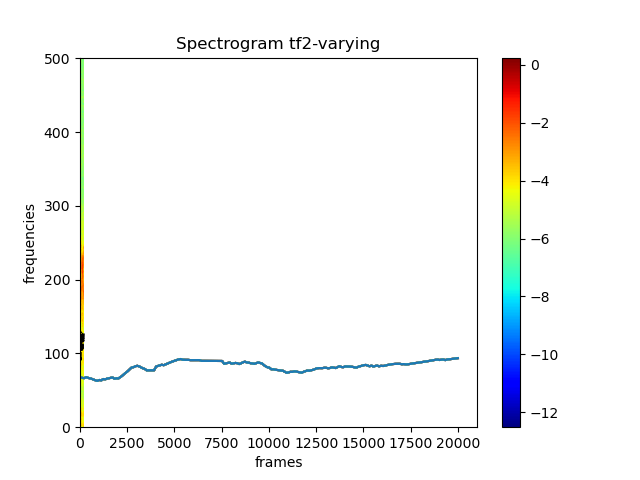

In [33]:
plt.plot(tmp['v'][:20_000])
plt.show()

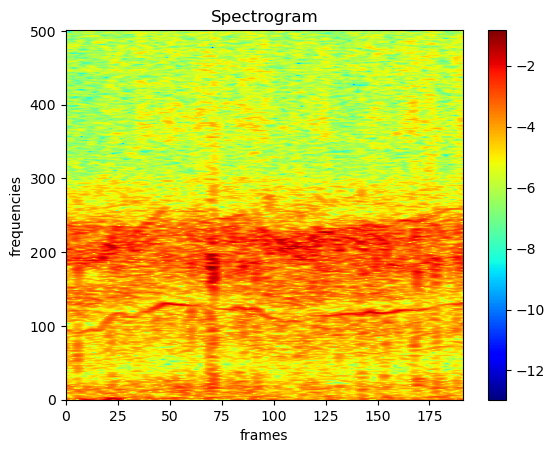

In [7]:
dstft = FDSTFT(x, win_length=1_000, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, *_ = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
vitesse['1000'] = spec.cpu() 

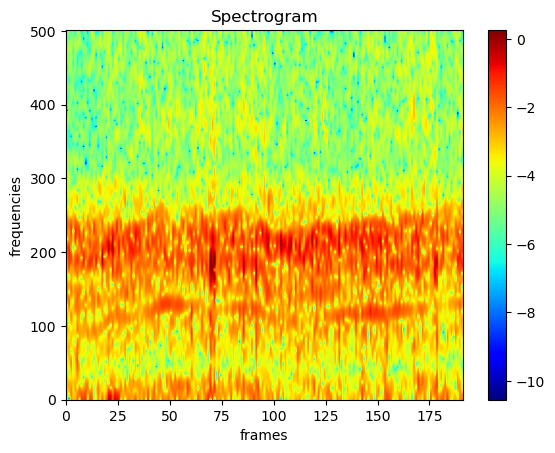

In [8]:
dstft = FDSTFT(x, win_length=100, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, *_ = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
vitesse['100'] = spec.cpu() 

Single window length

347 tensor(10.7615, device='cuda:0')


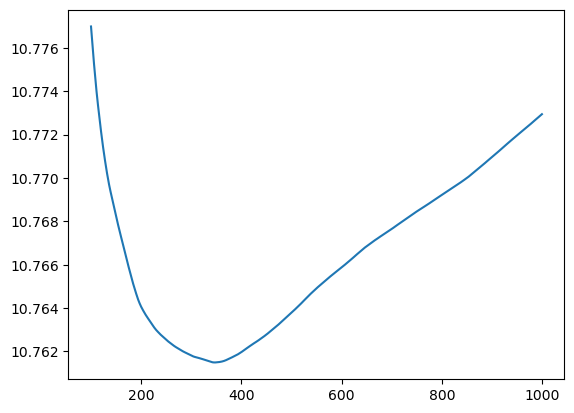

In [9]:
losses = []
min_err = 100
min_win = 0

for win_length in range(100, 1_000, 1):
    dstft = FDSTFT(x, win_length=win_length, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, *_ = dstft(x)
    err =  entropy_loss(spec) # 1_000 / kurtosis_loss(spec).mean()
    
    if err < min_err:
        min_err = err
        min_win = win_length
    losses.append(err.cpu())
    
print(min_win, min_err)
import matplotlib.pyplot as plt
plt.plot(range(100, 1000, 1), losses)

Epoch 00103: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00203: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00303: reducing learning rate of group 0 to 1.0000e-01.
302
316.8786926269531 tensor(10.7615, device='cuda:0', grad_fn=<MeanBackward0>)


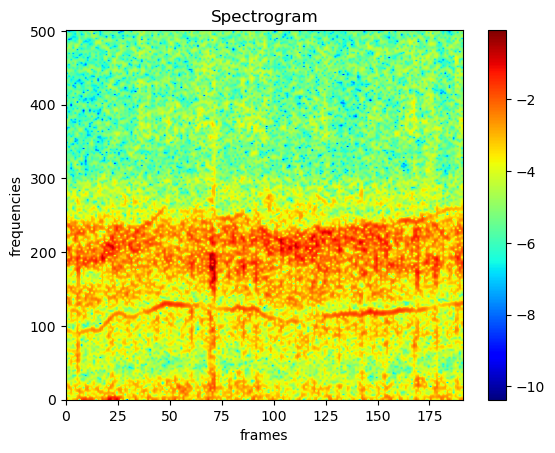

346.0


In [10]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

min_err = 100
min_win = 0

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < 1:
        break

vitesse['single'] = spec.cpu()
print(epoch)
print(min_win, min_err)
dstft.print(spec, x, bar=True, wins=False, weights=False)
print(f'{dstft.win_length.item():.1f}')

Time-varying window length

Epoch 00039: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00049: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00059: reducing learning rate of group 0 to 1.0000e-01.
58


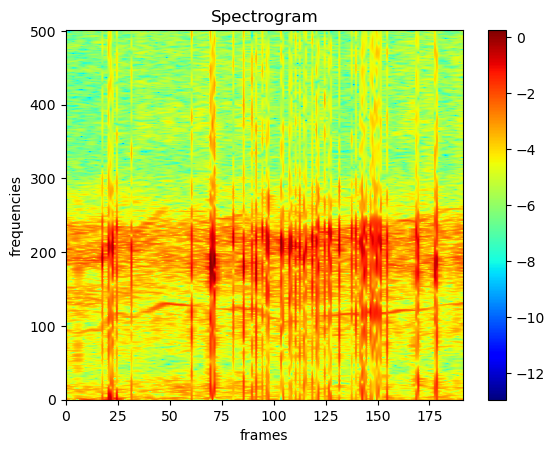

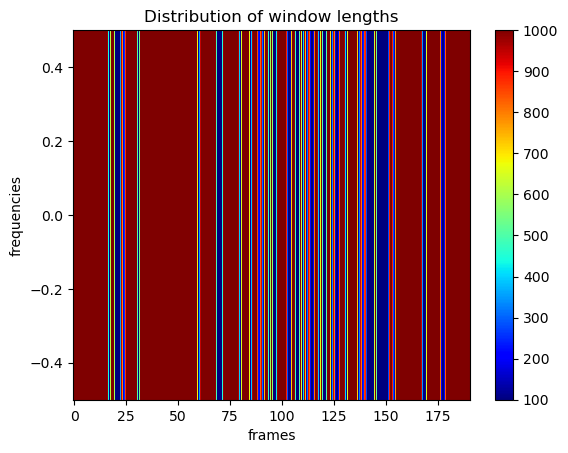

In [11]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


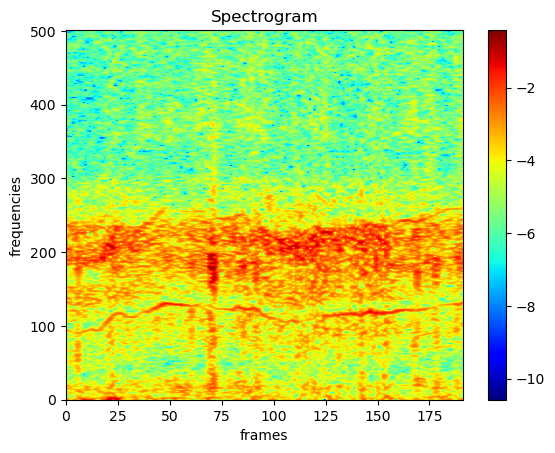

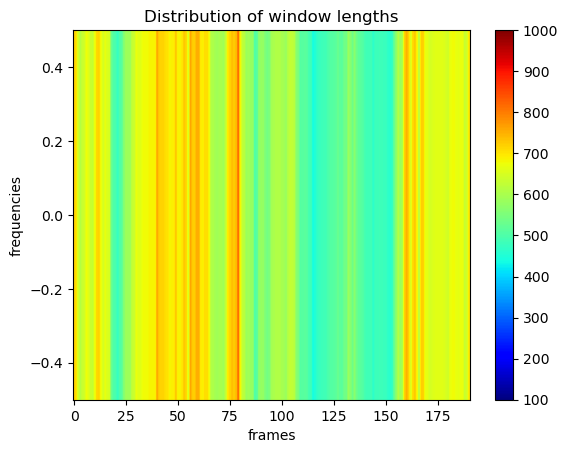

In [12]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.1 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

vitesse['time-varying'] = spec.cpu()
print(epoch)
dstft.print(spec, x, bar=True, wins=False,)

Frequency-varying window length

In [13]:
# dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
# params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
# opt = torch.optim.Adam(params)
# sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

# for epoch in range(1_000):
#     opt.zero_grad()
#     spec, *_ = dstft(x)
#     err = entropy_loss(spec)
#     err.backward()
#     opt.step()
#     sch.step(err)
    
#     if opt.param_groups[0]['lr'] < 1:
#         break
    
# print(epoch)
# dstft.print(spec, x, wins=False, bar=True)


In [14]:
# dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
# params = [{'params': dstft.win_length, 'lr': 100.0},  ]
# opt = torch.optim.Adam(params)
# sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

# for epoch in range(1_000):
#     opt.zero_grad()
#     spec, *_ = dstft(x)
#     err = entropy_loss(spec) + 0.001 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
#     err.backward()
#     opt.step()
#     sch.step(err)
    
#     if opt.param_groups[0]['lr'] < 1:
#         break
    
# print(epoch)
# dstft.print(spec, x, wins=False, bar=True)

Time-and-frequency-varying window length

Epoch 00058: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00080: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00090: reducing learning rate of group 0 to 1.0000e-01.
0 torch.Size([1, 20000]) 89
torch.Size([1, 501, 191]) torch.Size([501, 191])


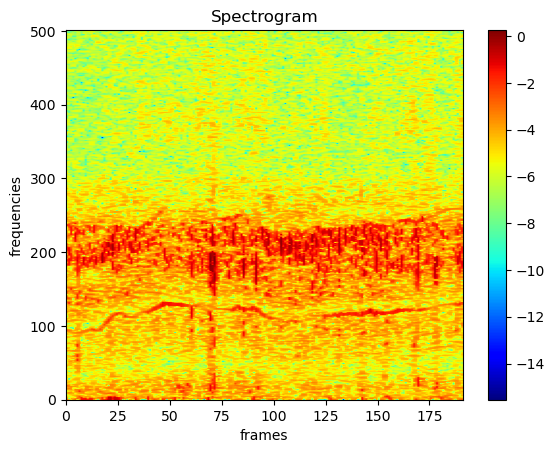

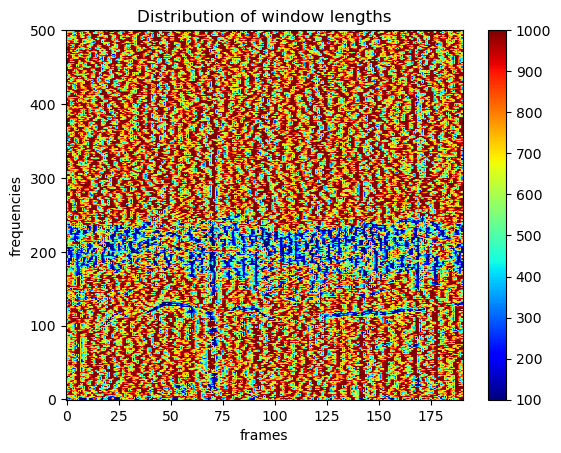

In [15]:
chunks = torch.split(x[0], 20_000)
#print(len(chunks))

spec_all = []
weight_all = []

for i, x_tmp in enumerate(chunks):    
    x_tmp = x_tmp[None, ...]
    
    
    dstft = DSTFT(x_tmp, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
    params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

    for epoch in range(1_000):
        opt.zero_grad()
        spec, *_ = dstft(x_tmp)
        err = entropy_loss(spec)
        err.backward()
        opt.step()
        sch.step(err)
        
        if opt.param_groups[0]['lr'] < 1:
            break
        
    print(i, x_tmp.shape, epoch)
    #dstft.print(spec, x_tmp, bar=True, wins=False)
    
    #print(spec.shape, dstft.actual_win_length[:dstft.F].detach().shape)
    spec_all.append(spec)
    weight_all.append(dstft.actual_win_length[:dstft.F].detach())
    
#specs = torch.stack(spec_all, 2)
#weights = torch.stack(weight_all, 2)

specs = spec_all[0]
#print(specs.shape, specs.dtype)
weights = weight_all[0]

size = len(spec_all)-1 

for i in range(size):
    specs = torch.cat((specs, spec_all[i+1]), dim=2)
    weights = torch.cat((weights, weight_all[i+1]), dim=1)

print(specs.shape, weights.shape)


plt.figure()
plt.title('Spectrogram')
ax = plt.subplot()
im = ax.imshow(specs[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,specs.shape[-1], 0, specs.shape[-2]])
vitesse['tf-varying'] = spec.cpu()
plt.ylabel('frequencies')
plt.xlabel('frames')
plt.colorbar(im, ax=ax)
plt.show()

plt.figure()
plt.title('Distribution of window lengths')
ax = plt.subplot()
im = ax.imshow(weights.detach().cpu(), aspect='auto', origin='lower', cmap='jet')
ax.set_ylabel('frequencies')
ax.set_xlabel('frames')
plt.colorbar(im, ax=ax)
im.set_clim(dstft.win_min, dstft.win_max)   
plt.show()   



Epoch 00114: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00147: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00161: reducing learning rate of group 0 to 1.0000e-01.
0 torch.Size([1, 20000]) 160
torch.Size([1, 501, 191]) torch.Size([501, 191])


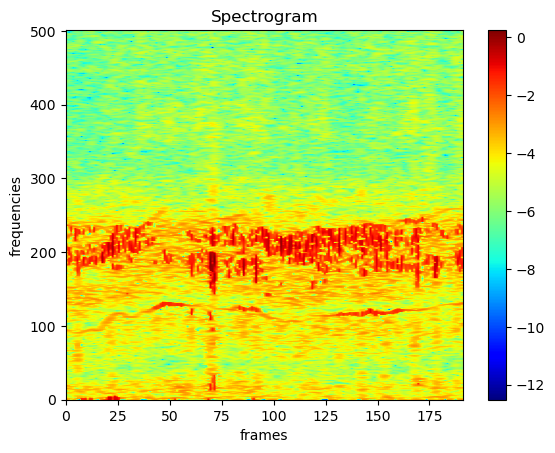

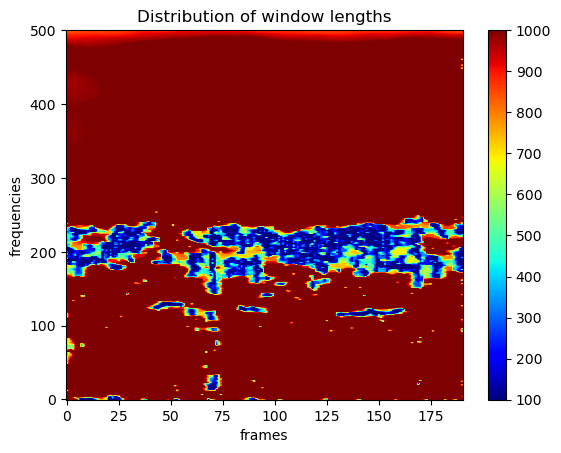

In [16]:
chunks = torch.split(x[0], 20_000)
#print(len(chunks))

spec_all = []
weight_all = []

for i, x_tmp in enumerate(chunks):    
    x_tmp = x_tmp[None, ...]
    
    
    dstft = DSTFT(x_tmp, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
    params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

    for epoch in range(1_000):
        opt.zero_grad()
        spec, *_ = dstft(x_tmp)
        err = entropy_loss(spec) + 0.005 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
        err.backward()
        opt.step()
        sch.step(err)
        
        if opt.param_groups[0]['lr'] < 1:
            break
        
    print(i, x_tmp.shape, epoch)
    #dstft.print(spec, x_tmp, bar=True, wins=False)
    
    #print(spec.shape, dstft.actual_win_length[:dstft.F].detach().shape)
    spec_all.append(spec)
    weight_all.append(dstft.actual_win_length[:dstft.F].detach())
    
#specs = torch.stack(spec_all, 2)
#weights = torch.stack(weight_all, 2)

specs = spec_all[0]
#print(specs.shape, specs.dtype)
weights = weight_all[0]

size = len(spec_all)-1 

for i in range(size):
    specs = torch.cat((specs, spec_all[i+1]), dim=2)
    weights = torch.cat((weights, weight_all[i+1]), dim=1)

print(specs.shape, weights.shape)


plt.figure()
plt.title('Spectrogram')
ax = plt.subplot()
im = ax.imshow(specs[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,specs.shape[-1], 0, specs.shape[-2]])
vitesse['tf2-varying'] = spec.cpu()
plt.ylabel('frequencies')
plt.xlabel('frames')
plt.colorbar(im, ax=ax)
plt.show()

plt.figure()
plt.title('Distribution of window lengths')
ax = plt.subplot()
im = ax.imshow(weights.detach().cpu(), aspect='auto', origin='lower', cmap='jet')
ax.set_ylabel('frequencies')
ax.set_xlabel('frames')
plt.colorbar(im, ax=ax)
im.set_clim(dstft.win_min, dstft.win_max)   
plt.show()   

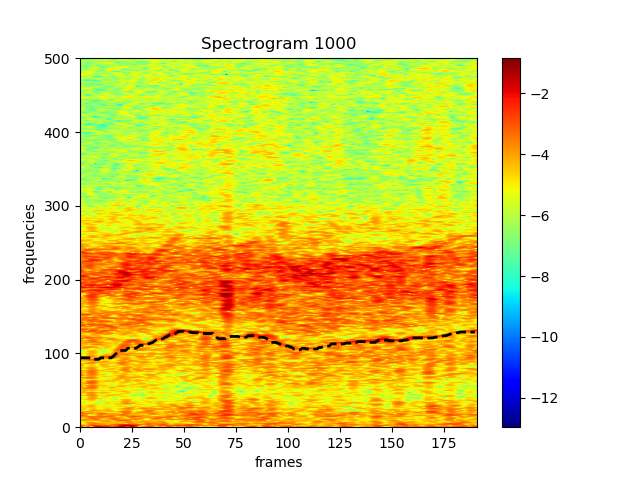

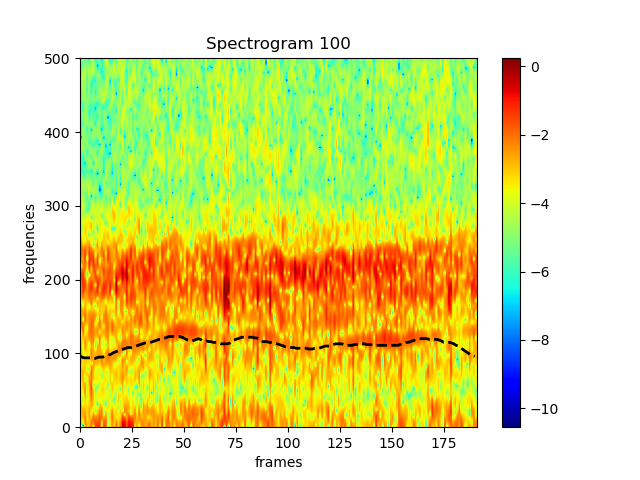

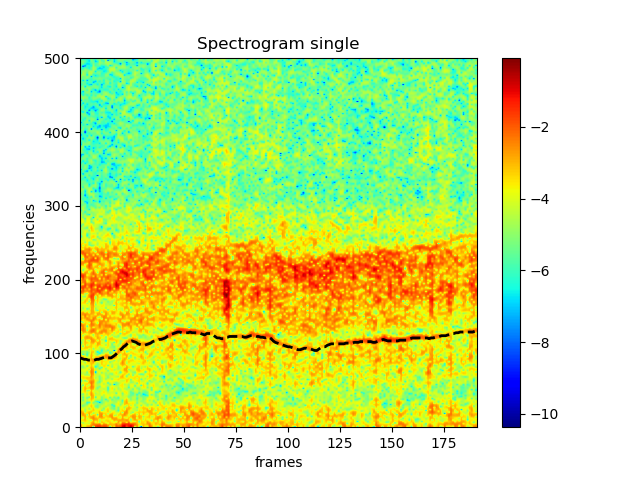

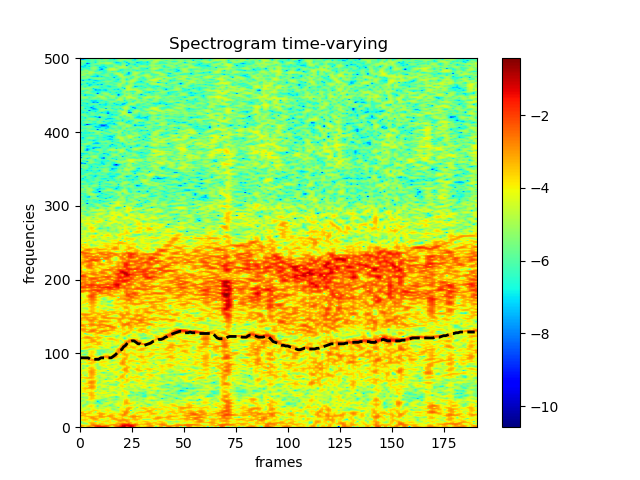

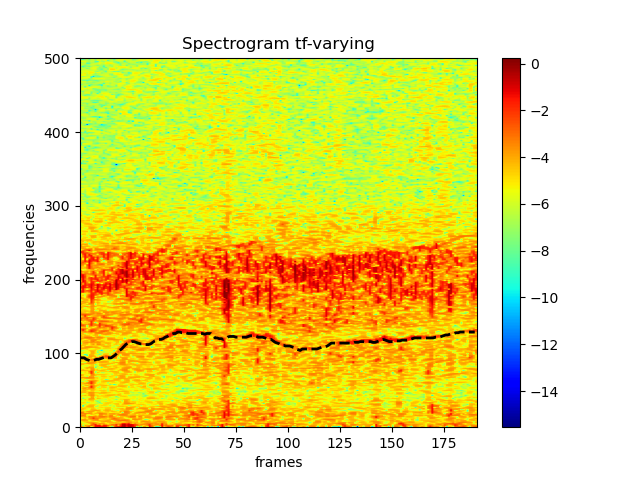

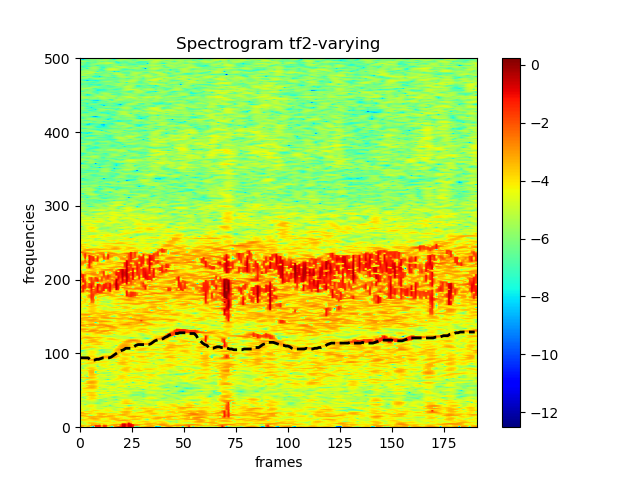

In [22]:
%matplotlib ipympl

freq = {}
outs = {}
for key, spec in vitesse.items():
    spec = spec[0]
    f_hat, out = frequency_tracking(y=x, fs=1, spec=spec, fmin=0, fmax=.5, alpha=1, orders=[2])
    freq[key] = f_hat
    outs[key] = out
    plt.figure()
    plt.title(f'Spectrogram {key}')
    ax = plt.subplot()
    im = ax.imshow(spec.detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    plt.ylabel('frequencies')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out, '--k', linewidth=2)
    plt.show()

torch.Size([20000])
torch.Size([191])


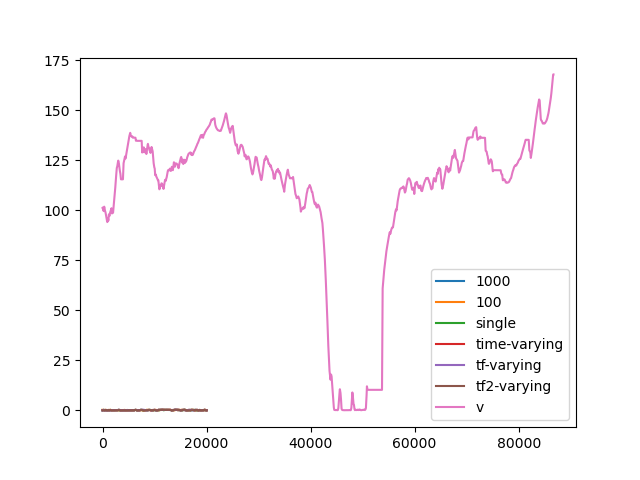

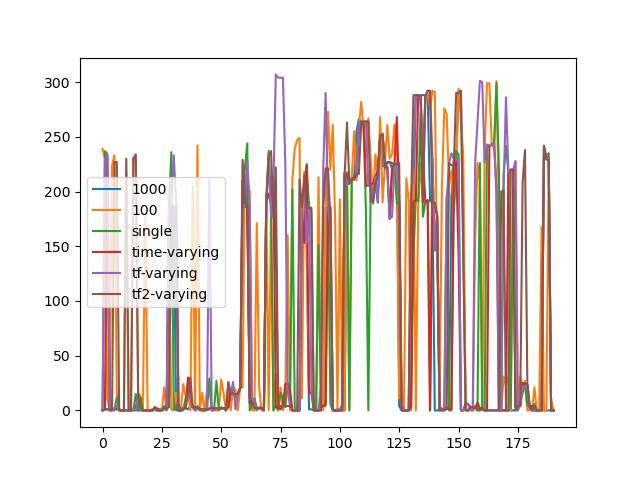

In [18]:
plt.figure()
for key, f in freq.items():
    plt.plot(f, label=key)
plt.plot(1.5*tmp['v'][:20_000], label='v')
plt.legend()

print(f.shape)

plt.figure()
for key, out in outs.items():
    plt.plot(out, label=key)
plt.legend()

print(out.shape)